In [1]:
import batoid
import galsim
import yaml
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%autoreload 2

In [3]:
# Load optics definitions

lsst = batoid.parse.parse_optic(
    yaml.load(
        open(
            os.path.join(batoid.datadir, 'LSST', 'LSST_r.yaml')
        )
    )['opticalSystem']
).withGloballyShiftedOptic('LSST.LSSTCamera', [0,0,1e-3])

hsc = batoid.parse.parse_optic(
    yaml.load(
        open(
            os.path.join(batoid.datadir, 'HSC', 'HSC.yaml')
        )
    )['opticalSystem']
).withGloballyShiftedOptic('SubaruHSC.HSC', [0,0,900e-6])

decam = batoid.parse.parse_optic(
    yaml.load(
        open(
            os.path.join(batoid.datadir, 'DECam', 'DECam.yaml')
        )
    )['opticalSystem']
).withGloballyShiftedOptic('BlancoDECam.DECam', [0,0,1e-3])

In [4]:
def psfModelComparison(telescope, theta_x, theta_y, wavelength,
                       nx=64, pad_factor=4, h_factor=8,
                       title=None):
    
    # Conversion factors
    dGnomicDX = batoid.psf.dthdr(telescope, theta_x, theta_y, wavelength)
    # dSphericalDGnomic = batoid.utils.dSphericalDGnomic(theta_x, theta_y)
    dSphericalDGnomic = np.eye(2, dtype=float)
    
    # Non-paraxial optics FFT PSF
    npFFTPSF = batoid.fftPSF(telescope, theta_x, theta_y, wavelength, 
                             nx=nx, pad_factor=pad_factor)
    npFFTSphericalPrimitives = np.dot(
        np.dot(
            npFFTPSF.primitiveVectors,
            dGnomicDX
        ),
        dSphericalDGnomic
    ) * galsim.radians/galsim.arcsec  # radians -> arcsec

    # Huygens PSF, using the same grid as for npFFT
    hPSF = batoid.huygensPSF(
        telescope, theta_x, theta_y, wavelength,
        nx=nx, nxOut=nx*pad_factor//h_factor,
        dx=npFFTPSF.primitiveVectors[0]*h_factor,
        dy=npFFTPSF.primitiveVectors[1]*h_factor
    )
    hSphericalPrimitives = np.dot(
        np.dot(
            hPSF.primitiveVectors,
            dGnomicDX
        ),
        dSphericalDGnomic
    ) * galsim.radians/galsim.arcsec
    
    print(hSphericalPrimitives)
    scale = np.sqrt(np.abs(np.linalg.det(hSphericalPrimitives.astype(float))))
    extent = np.r_[-1,1,-1,1]*0.5*nx*pad_factor//h_factor*scale

    fig, axes = plt.subplots(ncols=3, figsize=(9.5, 2.5))
    im1 = axes[0].imshow(npFFTPSF.array[::h_factor, ::h_factor], extent=extent)
    plt.colorbar(im1, ax=axes[0])
    im2 = axes[1].imshow(hPSF.array, extent=extent)
    plt.colorbar(im2, ax=axes[1])
    im3 = axes[2].imshow(npFFTPSF.array[::h_factor, ::h_factor] - hPSF.array, extent=extent)
    plt.colorbar(im3, ax=axes[2])

    if title:
        fig.suptitle(title)
    
    axes[0].set_title("FFT PSF")
    axes[1].set_title("Huygens PSF")
    axes[2].set_title("Residual")
    for ax in axes:
        ax.set_xlabel("arcsec")
        ax.set_ylabel("arcsec")
    
    fig.tight_layout(pad=2.0, w_pad=0.4)
    fig.show()

[[-0.4740467690070824 1.320149559846592e-07]
 [0.0 -0.4740556790435787]]


/Users/josh/src/lsstsw/miniconda/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


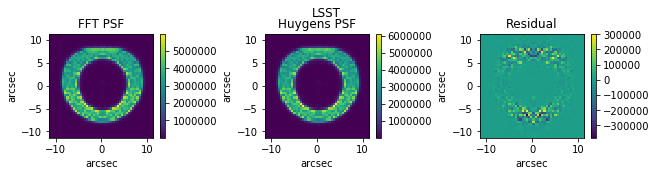

In [13]:
psfModelComparison(lsst, np.deg2rad(0.0), np.deg2rad(1.75), 600e-9, nx=1536, pad_factor=1, h_factor=32,
                   title="LSST")

[[-0.12084280718762215 3.2863504396926594e-06]
 [-9.859679687865582e-07 -0.12090130194937226]]


/Users/josh/src/lsstsw/miniconda/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


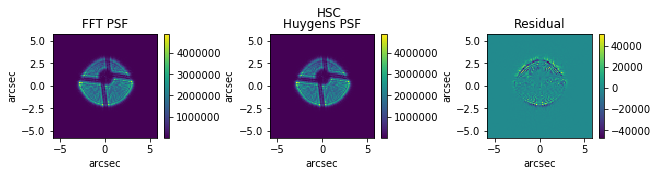

In [32]:
psfModelComparison(hsc, np.deg2rad(0.0), np.deg2rad(0.74), 600e-9, nx=768, pad_factor=1, h_factor=8,
                   title="HSC")

[[-0.12998224405338063 1.258342596513483e-08]
 [-1.4896145809963665e-13 -0.12999761538816268]]


/Users/josh/src/lsstsw/miniconda/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


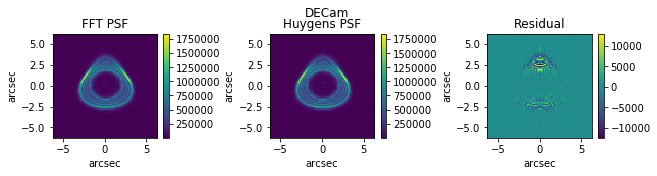

In [31]:
psfModelComparison(decam, np.deg2rad(0.0), np.deg2rad(1.1), 600e-9, nx=384, pad_factor=1, h_factor=4,
                   title="DECam")